In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import pandas as pd

## Dataset creation with hybrid model

In [4]:
attributes = ['title','authors','venue','year']

In [28]:
model = dm.MatchingModel(attr_summarizer='rnn')
model.load_state('../../models/dblp_acm_rnn.pth')

In [7]:
testneg,testneg_ids = return_layer_input('../../Structured/DBLP-ACM/','test_negatives',
                                                           batch_size=128,model=model,
                                                                         layer=model.classifier,device=-1)

In [29]:
testpos,testpos_ids = return_layer_input('../../Structured/DBLP-ACM/','test_positives',batch_size=128,model=model,
                                                layer=model.classifier,device=-1)

In [9]:
positives,pos_ids = return_layer_input('../../Structured/DBLP-ACM/','positives',
                                                           batch_size=128,model=model,layer=model.classifier,
                                                          device=-1)

In [10]:
negatives,neg_ids = return_layer_input('../../Structured/DBLP-ACM/','negatives',batch_size=128,
                                       model=model,layer=model.classifier,device=-1)

In [30]:
model = model.cuda()

In [12]:
## Basta scegliere un campione a caso
classifier_len = len(testneg[0][0])
attribute_len = int(classifier_len/len(attributes))

## Ri discovery with rnn model

In [13]:
neg_ri,neg_ri_norms = computeRi(model.classifier,attributes,testneg,attribute_len,1)

100%|██████████| 128/128 [00:18<00:00,  6.64it/s]


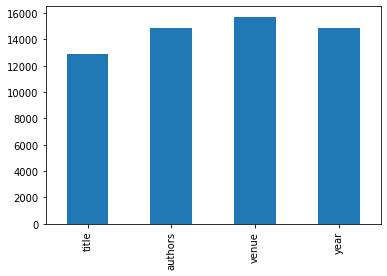

In [16]:
negatives_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
negatives_variation_df.sum(numeric_only=True).plot.bar()

### Positives

In [31]:
pos_ri,pos_ri_norms = computeRi(model.classifier,attributes,testpos,attribute_len,0)

100%|██████████| 128/128 [00:03<00:00, 30.61it/s]


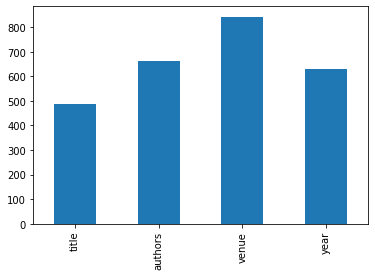

In [32]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum().plot.bar()

In [33]:
negatives_variation_df.to_csv('experiment_results/testneg_ri_rnn.csv',index=False)

In [34]:
positives_variation_df.to_csv('experiment_results/testpos_ri_rnn.csv',index=False)

## Nearest neighbors discovery on Rnn model

In [35]:
from utils.distance_measures import calculate_nearest_neighbors_onAttributes

In [36]:
negatives_closer_vectors_df = calculate_nearest_neighbors_onAttributes(testneg,testneg_ids,neg_ri,
                                                                      positives,pos_ids,attributes,attribute_len,
                                                                      min_similarity=0.5)

100%|██████████| 128/128 [00:00<00:00, 479.02it/s]


In [37]:
negatives_closer_vectors_df.to_csv('experiment_results/testneg_nn_rnn.csv',index=False)

In [38]:
positives_closer_vectors_df = calculate_nearest_neighbors_onAttributes(testpos,testpos_ids,pos_ri,
                                                                      negatives,neg_ids,
                                                                      attributes,attribute_len,min_similarity=0.5)

100%|██████████| 128/128 [00:01<00:00, 120.80it/s]


In [39]:
positives_closer_vectors_df.to_csv('experiment_results/testpos_nn_rnn.csv',index=False)